# Upstream Regulator Analysis
## Basic Example
### Direct Module Use, No Wrapper Class

----------------------

Author: Mikayla Webster (m1webste@ucsd.edu)

Date: 8th November, 2017

----------------------

<a id='toc'></a>
## Table of Contents
1. [Background](#background)
2. [Import packages](#import)
3. [Create Graph](#graph)
    1. [Transcription Factors](#tf)
    2. [Background Network](#bn)
    3. [Differentially Expressed Genes](#deg)
3. [Stat Analysis](#stat)
    1. [P-value](#pvalue)
    2. [Z-score](#zscore)
    3. [Display Our Results](#display)
        1. [Top Values](#top)
        2. [Rank with z-score](#rank)
        3. [Network Visualization using visJS2jupyter](#visJS)

## Background
<a id='background'></a>

The inspiration for these modules comes from Ingenuity System's [Ingenuity Upstream Regulator Analysis in IPA®](http://pages.ingenuity.com/rs/ingenuity/images/0812%20upstream_regulator_analysis_whitepaper.pdf).

This notebook is meant to explain how to use the individual functions from our URA modules, with emphasis on different parameter options. If you need further help on how to use a function or what that function's purpose is, see the comments associated with that function in the source code (create_graph.py or stat_analysis.py).

## Import packages
<a id='import'></a>

In [1]:
# import upstream regulator modules
import sys
import networkx as nx
code_path = '../../ura'
sys.path.append(code_path)
import create_graph
import stat_analysis
reload(create_graph)
reload(stat_analysis)

# import matplotlib for color map
import matplotlib as plt

In [18]:
%matplotlib inline

In [2]:
# declare which gene naming convention you would like to use
gene_type = 'symbol'

## Create Graph ##
<a id='graph'></a>

### Transcription Factors
<a id='tf'></a>

Our create_graph module prepares 3 databases to use in our analysis: a transcription factor interaction network, a background network, and a differentially expressed genes database. Our transcription factor data comes from two sources: [slowkow](https://github.com/slowkow/tftargets) and [jaspar](http://jaspar.genereg.net/). Slowkow is a compilation of 6 smaller databases: TRED, ITFP, ENCODE, Neph2012, TRRUST, Marbach2016. Information about these specific databases, including links to their sources, is available through the slowkow github page. Some basic information on these databases is as follows:
- Size of Jaspar Database: 2049
- Size of Slowkow Database: 2705
- Size of TRED: 133
- Size of ITFP: 1974
- Size of ENCODE: 157
- Size of Neph2012: 536
- Size of TRRUST: 748
- Size of Marbach2016: 643 

Our trascription factor list contains 3983 unique entries.

In [3]:
TF_list = create_graph.easy_load_TF_list(slowkow_bool=True,
                                         slowkow_files=['../../TF_databases/slowkow_databases/TRED_TF.txt',
                                         '../../TF_databases/slowkow_databases/ITFP_TF.txt',
                                         '../../TF_databases/slowkow_databases/ENCODE_TF.txt',
                                         '../../TF_databases/slowkow_databases/Neph2012_TF.txt',
                                         '../../TF_databases/slowkow_databases/TRRUST_TF.txt',
                                         '../../TF_databases/slowkow_databases/Marbach2016_TF.txt'],
                                         jaspar_bool=True,
                                         jaspar_file="../../TF_databases/jaspar_genereg_matrix.txt",
                                         gene_type = gene_type)
len(TF_list)

3983

### Background Network
<a id='bn'></a>

Our background network comes from the [STRING](https://string-db.org/) database. Our module uses our list of transcription factors (TF_list) to extract only relevant information from the STRING database. Namely, we remove all edges and nodes not conected to our TF's.

This function may need a minute or so to process.

In [4]:
filename = "../../background_networks/9606.protein.actions.v10.5.txt"
DG_TF, DG_universe = create_graph.load_STRING_to_digraph(filename, 
                                                         TF_list, 
                                                         confidence_filter=400, 
                                                         gene_type = gene_type)

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-7374...done.
Finished.
56 input query terms found dup hits:
	[(u'ENSP00000359550', 3), (u'ENSP00000447879', 2), (u'ENSP00000364076', 2), (u'ENSP00000348986', 2),
312 input query terms found no hit:
	[u'ENSP00000376684', u'ENSP00000289352', u'ENSP00000202788', u'ENSP00000373637', u'ENSP00000367802',
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


In [5]:
print 'Number of unique nodes without filtering: ' + str(len(list(set(DG_universe.nodes()))))
print 'Number of edges without filtering: ' + str(len(DG_universe.edges()))
print '-----------------------------------------------'
print 'Number of unique nodes with filtering: ' + str(len(list(set(DG_TF.nodes()))))
print 'Number of edges with filtering: ' + str(len(DG_TF.edges()))

Number of unique nodes without filtering: 7050
Number of edges without filtering: 140382
-----------------------------------------------
Number of unique nodes with filtering: 4613
Number of edges with filtering: 28939


### Differentially Expressed Genes
<a id='deg'></a>

Our last database comes from a list of differentially exressed genes (DEG) found in an experiement. This should come in the form of a tab separated csv file with at least three columns: gene name, (adjusted) p-value, and (log) fold change. Our parser will look for common header names for each of these columns. However, if your file has unusual column headers for any of these three categories, please specify your column headers using the parameters "gene_column_header", "p_value_column_header", and "fold_change_column_header".

**WARNING: Having spaces in your column headers can cause weird bugs.**

Specify a networkx graph G in order to add the fold change (up-down) information from your csv file as a node attribute to this graph. NOTE: 1) the graph will not be modified in place, and 2) if G is not specified, 3 values will be returned rather than 2.

In [6]:
filename = '../../DEG_databases/differentially_expressed_genes.txt'

# specified a networkx graph G
DEG_list, DG_TF = create_graph.create_DEG_list(filename,
                G = DG_TF,  # specify in order to add up-down info to graph
                p_value_filter = 0.05,
                p_value_or_adj = 'adj',  # filtering by p-value ('p') or adjusted p-value ('adj')
                fold_change_filter = None,  # specify a number to filter by absolute (log) fold change
                gene_type = gene_type,  # 'symbol' or 'entrez'
                gene_column_header = 'gene_symbol', # these are common names, but specifying for demonstration
                p_value_column_header = 'adj_p_value',
                fold_change_column_header = 'fold_change')

# did NOT specify a networkx graph G
# all of the parameters listed above are to default parameters (except for G), and those column headers
# are considered common header names
DEG_list, DEG_to_pvalue, DEG_to_updown = create_graph.create_DEG_list(filename)
print "Number of DEG's: " + str(len(DEG_list))

Number of DEG's: 8755


In [7]:
DG_TF.nodes(data=True) # updown means fold change

[('HIF3A', {'updown': 0}),
 ('RNF14', {'updown': 0.3508037846}),
 (u'ELANE', {'updown': 0}),
 (u'CCNE1', {'updown': 0.99438934690000003}),
 (u'NCBP1', {'updown': 0.9955238004000001}),
 ('NCBP2', {'updown': 0.99833423890000006}),
 ('RNF13', {'updown': 0}),
 ('NELFB', {'updown': 0.99337302000000005}),
 (u'HIST1H4J', {'updown': 0.99796412239999999}),
 (u'HSPA9', {'updown': 0.84444869430000002}),
 (u'HSPA8', {'updown': 0.94796409299999995}),
 (u'NELFE', {'updown': 0}),
 (u'B2M', {'updown': 0.99801843430000003}),
 (u'CD226', {'updown': 0}),
 (u'LIFR', {'updown': 0}),
 (u'CSNK2A2', {'updown': 0.99833392330000004}),
 (u'PDCD10', {'updown': 0.13305126619999999}),
 ('PDCD11', {'updown': 0.99801437659999992}),
 (u'AGT', {'updown': 0.99818587799999992}),
 (u'ASS1', {'updown': 0.43299072960000001}),
 (u'SQLE', {'updown': 0.99742004290000008}),
 (u'ADIPOQ', {'updown': 0}),
 (u'FHIT', {'updown': 0.99766488060000003}),
 (u'CEACAM1', {'updown': 0}),
 ('SRY', {'updown': 0}),
 (u'HSPA5', {'updown': 0.94

Our package also has a function to load your entire DEG file into a networkx graph, without filtering by p-value or fold change. This function will return a networkx graph representation of your entire specified csv file, a dictionary mapping genes to their (adj) p-values, and a dictionary mapping genes to their (log) fold change

In [8]:
DEG_full_graph, DEG_to_pvalue, DEG_to_updown = create_graph.create_DEG_full_graph(filename,
                    p_value_or_adj='adj',  # filtering by p-value ('p') or adjusted p-value ('adj')
                    gene_type=gene_type,  # 'symbol' or 'entrez'
                    gene_column_header = 'gene_symbol', # these are common names, but specifying for demonstration
                    p_value_column_header = 'adj_p_value',
                    fold_change_column_header = 'fold_change')
print "Number of genes in our entire input file: " + str(len(DEG_full_graph.nodes()))

Number of genes in our entire input file: 13297


## Stat Analysis
<a id='stat'></a>

Our stat_analysis package can help identify TF's that are statistically significant to our set of DEG's.

### Enrichment
<a id='pvalue'></a>

Given you have run the appropriate prerequisite functions, you can now start to anaylize your data! First, we check how enriched our set of TF's are. All of our p-value functions calculate the log of the p-value using [scipy.stats.hypergeom.logsf](https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.stats.hypergeom.html).

In [9]:
# Enrichment of TF's
tf_enrich = stat_analysis.tf_enrichment(TF_list, DEG_full_graph, DEG_list)   
tf_enrich

TF_ENRICHMENT    8.308021e-12
dtype: float64

Next we can check how enriched each TF's targets are.  These values help us determine which TF's are actually associated with our DEG's. 
- high value = significant connection between this TF and its DEG targets
- low value = TF is randomly associated with its DEG targets
- zero = None of this TF's targets were DEG's
- inf = original p-value was so small that its log is inf. Very high significance.

This function may need a minute or so.

In [10]:
tf_target_pvalues = stat_analysis.tf_target_enrichment(DG_TF, DG_universe, DEG_list)

In [11]:
df = tf_target_pvalues.to_frame()
df = df.loc[df['tf-target enrichment'] != 0]
df = df.loc[df['tf-target enrichment'] != float('inf')] # removing zeros and inf's for the sake of visualization
display(df)

,tf-target enrichment
AAAS,2.306869e+01
ELL,2.058271e+01
RAE1,2.034444e+01
NUP50,2.016211e+01
TPR,1.958330e+01
RANBP2,1.771874e+01
NUP37,1.696152e+01
NFRKB,1.514671e+01
NCBP2,1.475362e+01
NUP133,1.437584e+01


### Z-score
<a id='zscore'></a>

The goal of our z-score function is to predict the activation states of the TF's. We observe how a TF relates to each of its targets to make our prediction. We compare each targets' observed gene regulation (either up or down) and each TF-target interation (whether it is activating or inhibiting) to conclude whether a TF is activating or inhibiting. A positive value indicates activating while a negative value indicates inhibiting. A value of zero means that we did not have enough information about the target or TF-target interaction to make the prediction.

Our z-score calculater has to calculation methods. Our method calculates how "biased" the background network is towards either activating or inhibiting interactions, then adjusts its calculations to that non-zero average. Our bias-filter parameter is a number between 0 and 1 that indicates the threshold at which the graph is considered "too biased", and therefore the bias z-score formula must be used.

This function may need a minute or so.

In [12]:
unbiased_zscores = stat_analysis.tf_zscore(DG_TF, DEG_list, bias_filter = 1) # To explicitly use not-biased formula, set to 1
display(unbiased_zscores.to_frame())

,unbiased-calculated z-scores
RANBP2,12.609520
NUP133,12.609520
NUP37,12.288206
XPO1,10.049876
PAFAH1B1,9.433981
CLIP1,9.327379
CENPA,9.219544
CKAP5,9.165151
NUP50,9.165151
CLASP1,9.165151


In [13]:
bias_zscore = stat_analysis.tf_zscore(DG_TF, DEG_list, bias_filter = 0) # To explicitly use bias formula, set to 0
display(bias_zscore.to_frame())

Graph has bias of 0.362797608763. Adjusting z-score calculation accordingly.


,biased-calculated z-scores
RANBP2,101.315180
NUP133,101.315180
NUP37,96.217561
XPO1,64.357442
PAFAH1B1,56.711013
CLIP1,55.436608
CENPA,54.162203
CLASP1,53.525001
NUP50,53.525001
CKAP5,53.525001


### Display Results
<a id='display'></a>

Our stat_analysis module also inculdes methods to help you find the most statistically relevant TF's to your input DEG data set.
- top_values: will display the highest activating, inhibiting, or overall values
- rank_and_score_df: will display where an input set of genes rank among all others in terms of their z-score
- vis_tf_network: will display an interactive network of a specified regulator and its downstream targets

**Top Values**
<a id='top'></a>

NOTE: Your DEG_to_pvalue and DEG_to_updown paramters should come from create_DEG_full_graph

In [14]:
top_act = stat_analysis.top_values(bias_zscore, DEG_to_pvalue, DEG_to_updown, act = True, abs_value = False, top = 5)
top_inh = stat_analysis.top_values(bias_zscore, DEG_to_pvalue, DEG_to_updown, act = False, abs_value = False, top = 5)
top_overall = stat_analysis.top_values(bias_zscore, DEG_to_pvalue, DEG_to_updown, abs_value = True, top = 5)

print "\nTop five activating: "
display(top_act)
print "\nTop five inhibiting: "
display(top_inh)
print "\nTop five overall: "
display(top_overall)


Top five activating: 


,z-score,(adj) p-value,(log) fold change
RANBP2,101.315180,-0.090858,0.975454
NUP133,101.315180,-0.115508,0.600609
NUP37,96.217561,0.006546,0.998296
XPO1,64.357442,0.046577,0.997240
PAFAH1B1,56.711013,-0.241807,0.008217



Top five inhibiting: 


,z-score,(adj) p-value,(log) fold change
AKT2,-77.182142,0.056609,0.978390
AKT3,-70.916963,-0.136716,0.058052
AKT1,-63.852379,0.099134,0.019114
GPSM1,-62.688690,0.159024,0.010397
CCNE2,-49.149107,NaN,NaN



Top five overall: 


,z-score,(adj) p-value,(log) fold change
NUP133,101.315180,-0.115508,0.600609
RANBP2,101.315180,-0.090858,0.975454
NUP37,96.217561,0.006546,0.998296
AKT3,-70.916963,-0.136716,0.058052
AKT2,-77.182142,0.056609,0.978390


**Rank with z-score**
<a id='rank'></a>

Ranks range from 0 (best, aka strongest z-score) to whichever number is associated with a z-score of zero, in this case 47. If the remove_dups flag is set to True, any genes with the same z-score will have the same rank. 

RPL8 is not a valid transcription factor in our graph.
ZEN2 is not a valid transcription factor in our graph.


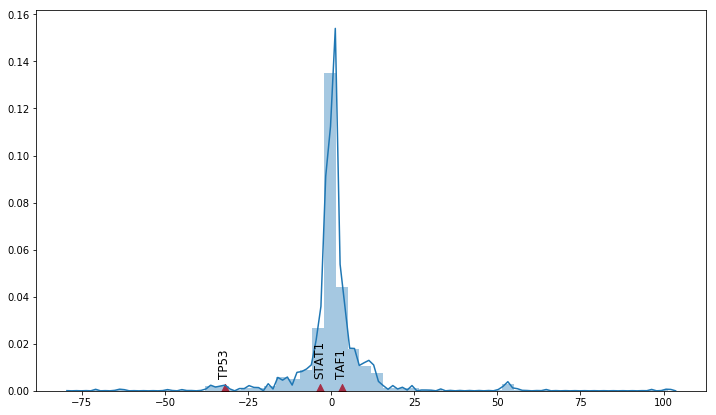

In [22]:
genes_to_rank = ['TAF1', 'RPL8', 'STAT1','TP53', 'ZEN2']
stat_analysis.compare_genes(bias_zscore, genes_to_rank, anno_vert_dist=0.005)

**Network Visualization using visJS2jupyter**
<a id='visJS'></a>

If you do not already have the package visJS2jupyter, type "pip install visJS2jupyter" into your command prompt.

**Node Color**:
- yellow: regulator/TF
- red: up-regulated tarets
- blue: down-regulated targets
- the stronger the gene's fold change (specified in DEG_filename), the stronger the shade of red or blue
- white: no fold change information for this gene

**Node Border**:
- DEG's (secified by DEG_list) are outlined in black

**Node Size**:
- small: insiginificant/large adjusted p-value (taken from DEG_filename)
- large: significant/small adjusted p-value

**Edge Color**:
- red: activating
- blue: inhibiting

**Tips**:
- nodes look too clustered: increase node spacing to ~3000 or ~4000
- nodes look to sparse: decrease node spacing to ~2000 or ~1000
- directed_edges = False will center the TF
- directed_edges = True will pull the TF off to the side

**NOTE:** Unfortunately there is a bug with just this notebook, where any nodes that are not "circle" shaped may not appear in the graph visual. The TF is set to always be "star" shaped...

In [ ]:
stat_analysis.vis_tf_network(DG_TF, 'STAT1', filename, list(DEG_list),
                   directed_edges = False,
                   node_spacing = 3200,
                   color_non_DEGs = True,
                   color_map = plt.cm.bwr,
                   graph_id = 200,
                   tf_size_amplifier = 1000
                   ) 

In [ ]:
stat_analysis.vis_tf_network(DG_TF, 'STAT5A', filename, list(DEG_list),
                   directed_edges = True,
                   node_spacing = 3000,
                   color_non_DEGs = False,
                   color_map = plt.cm.bwr,
                   graph_id = 201,
                   tf_size_amplifier = 8
                   ) 

In [ ]:
stat_analysis.to_csv(out_filename = 'example_basic.txt', 
                     z_score_series = bias_zscore, 
                     DEG_to_pvalue = DEG_to_pvalue, 
                     DEG_to_updown = DEG_to_updown, 
                     tf_target_enrichment = tf_enrich, 
                     DG_TF = DG_TF)